In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import sklearn.preprocessing as pp
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('Training Data.csv')
df.sample(5)

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
61972,61973,110437,41,8,single,rented,no,Police_officer,Gopalpur,West_Bengal,8,12,1
39071,39072,5570090,74,1,single,rented,no,Politician,Bardhaman,West_Bengal,1,11,0
169133,169134,1047915,23,4,single,rented,yes,Artist,Dhule,Maharashtra,4,11,1
38143,38144,368667,48,2,married,rented,no,Computer_operator,Moradabad,Uttar_Pradesh,2,13,0
106555,106556,5360213,64,12,single,rented,yes,Chartered_Accountant,Siwan[32],Bihar,4,14,0


## <font color = 'green'> Data Cleansing </font>

### A. Handling Missing Value

In [5]:
df.isna().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

Tidak perlu handling missing value sebab tidak ditemukan data NULL.

### B. Handling Duplicated Data

In [6]:
df.duplicated().sum()

0

Tidak ada data duplikat.

### C. Cleaning Data

In [7]:
df['CITY'] = df['CITY'].str.extract("([A-Za-z]+)")
df['STATE'] = df['STATE'].str.extract("([A-Za-z]+)")

### D. Handle Outliers

In [8]:
num_cols = df.select_dtypes(include=['int', 'float'])
num_cols.columns

Index(['Id', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag'],
      dtype='object')

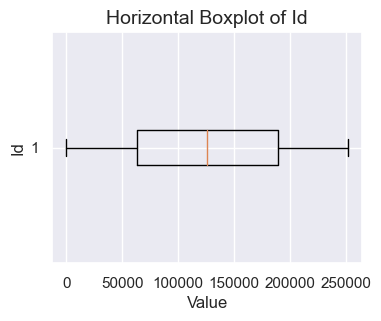

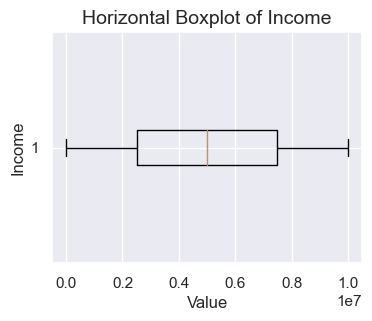

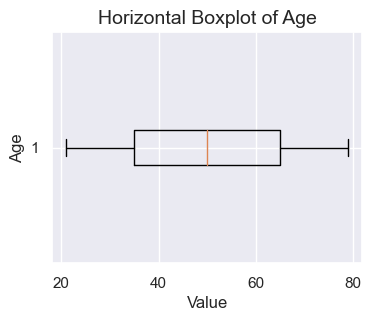

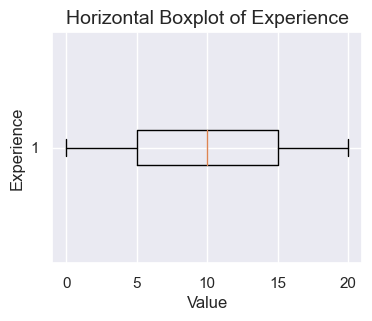

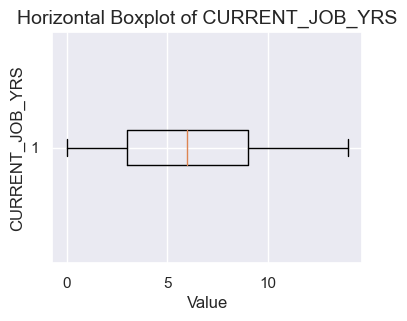

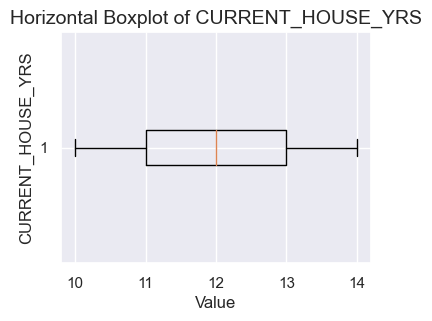

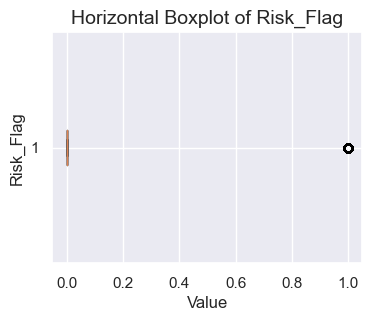

In [9]:
for col in num_cols.columns:
    plt.figure(figsize=(4, 3))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Horizontal Boxplot of {col}', fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.show()

Tidak ada handle outlier dan akan menggunakan model yang robust terhadap outlier.

### E. Feature transformation

In [10]:
# Mengecek tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


Tidak perlu feature transformation karena tipe data semua feature sudah sesuai.

### F. Feature encoding

In [11]:
label_encoder = pp.LabelEncoder()
df['Married_Single_Encode'] = label_encoder.fit_transform(df['Married/Single'])
df['Car_Ownership_Encode'] = label_encoder.fit_transform(df['Car_Ownership'])
df['House_Ownership_Encode'] = label_encoder.fit_transform(df['House_Ownership'])
df['Profession_Encode'] = label_encoder.fit_transform(df['Profession'])
df['CITY_Encode'] = label_encoder.fit_transform(df['CITY'])
df['STATE_Encode'] = label_encoder.fit_transform(df['STATE'])

Berdasarkan Chi-Square Test Categorical Columns memiliki pengaruh signifikan terhadap fitur target `Risk_Flag`.

### G. Handling class imbalance

In [12]:
df['Risk_Flag'].value_counts(normalize=True)

Risk_Flag
0    0.877
1    0.123
Name: proportion, dtype: float64

## <font color = 'green'> Feature Engineering </font>

In [13]:
# membuat kolom Age_Group
bins = [20, 35, 50, 65, 80]
labels = ['21-35', '36-50', '51-65', '66-79']

df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df['Age_Group_Encode'] = label_encoder.fit_transform(df['Age_Group'])

In [14]:
# membuat kolom Income_Category
bins = [10310, 2503015, 5000694, 7477502, 9999938]
labels = ['Low', 'Medium', 'High', 'Very High']

df['Income_Category'] = pd.cut(df['Income'], bins=bins, labels=labels)
df['Income_Category_Enocode'] = label_encoder.fit_transform(df['Income_Category'])

In [15]:
# membuat kolom Experience_Category
bins = [0, 5, 10, 15, 20]
labels = ['Amateur', 'Intermediate', 'Experienced', 'Expert']
df['Experience_Category'] = pd.cut(df['Experience'], bins=bins, labels=labels, right=False)
df['Experience_Category_Encode'] = label_encoder.fit_transform(df['Experience_Category'])

In [16]:
# membuat kolom profession_map 
def segment_profession(profession):
    if profession in ['Mechanical_engineer', 'Design_Engineer', 'Chemical_engineer', 'Biomedical_Engineer',
                      'Computer_hardware_engineer', 'Petroleum_Engineer', 'Civil_engineer',
                      'Industrial_Engineer', 'Technology_specialist', 'Surveyor']:
        return 'Engineering'
    elif profession in ['Software_Developer', 'Technical_writer', 'Graphic_Designer', 'Web_designer']:
        return 'IT/Software'
    elif profession in ['Civil_servant', 'Politician', 'Police_officer', 'Magistrate', 'Official', 'Army_officer']:
        return 'Government'
    elif profession in ['Librarian', 'Teacher']:
        return 'Education'
    elif profession in ['Economist', 'Financial_Analyst', 'Chartered_Accountant']:
        return 'Finance/Accounting'
    elif profession in ['Flight_attendant', 'Air_traffic_controller', 'Aviator']:
        return 'Aviation'
    elif profession in ['Architect', 'Designer', 'Fashion_Designer']:
        return 'Design'
    elif profession in ['Physician', 'Dentist', 'Surgeon','Psychologist']:
        return 'Medical Practitioner'
    elif profession in ['Hotel_Manager', 'Chef']:
        return 'Hospitality'
    elif profession in['Comedian', 'Artist']:
        return 'Art'
    elif profession in ['Secretary', 'Computer_operator']:
        return 'Administration'
    elif profession in ['Technician', 'Microbiologist', 'Geologist','Scientist', 'Geologist', 'Statistician','Analyst']:
        return 'Science/Research'
    else:
        return 'Other'

df['profession_map'] = df['Profession'].apply(segment_profession)

In [17]:
df['profession_map_encode'] = label_encoder.fit_transform(df['profession_map'])

In [18]:
# membuat kolom Zone
def segment_state(state):
    if state in ['Rajasthan', 'Maharashtra', 'Gujarat']:
        return 'West Zone'
    elif state in ['Andhra_Pradesh','Kerala', 'Tamil_Nadu', 'Puducherry','Telangana','Karnataka']:
        return 'South Zone'
    elif state in ['Jammu_and_Kashmir','Himachal_Pradesh', 'Punjab','Chandigarh', 'Uttarakhand', 'Haryana','Delhi', 'Uttar_Pradesh','Uttar_Pradesh']:
        return 'North Zone'
    elif state in ['Bihar','West_Bengal','Jharkhand', 'Odisha',]:
        return 'East Zone'
    elif state in ['Chhattisgarh','Madhya_Pradesh']:
        return 'Central Zone'
    elif state in ['Sikkim','Mizoram', 'Manipur','Tripura','Arunachal Pradesh','Assam']:
        return 'North East Zone'
    else:
        return 'Unknown'

df['Zone'] = df['STATE'].apply(segment_state)

In [19]:
df['Zone_Encode'] = label_encoder.fit_transform(df['Zone'])

In [20]:
df.head(2)

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,...,Age_Group,Age_Group_Encode,Income_Category,Income_Category_Enocode,Experience_Category,Experience_Category_Encode,profession_map,profession_map_encode,Zone,Zone_Encode
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya,...,21-35,0,Low,1,Amateur,0,Engineering,5,Unknown,5
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,...,36-50,1,Very High,3,Experienced,1,IT/Software,9,West Zone,6


## <font color = 'green'> Descriptive Analysis </font>

In [21]:
numeric_cols = df.select_dtypes(include=['int', 'float'])
categorical_cols = df.select_dtypes(include=['object', 'category'])

In [21]:
# Analisis Summary Kolom Numeric
numeric_cols.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Id,252000.0,1.260005e+05,7.274628e+04,1.0,63000.75,126000.5,189000.25,252000.0
Income,252000.0,4.997117e+06,2.878311e+06,10310.0,2503015.00,5000694.5,7477502.00,9999938.0
Age,252000.0,4.995407e+01,1.706385e+01,21.0,35.00,50.0,65.00,79.0
Experience,252000.0,1.008444e+01,6.002590e+00,0.0,5.00,10.0,15.00,20.0
CURRENT_JOB_YRS,252000.0,6.333877e+00,3.647053e+00,0.0,3.00,6.0,9.00,14.0
CURRENT_HOUSE_YRS,252000.0,1.199779e+01,1.399037e+00,10.0,11.00,12.0,13.00,14.0
Risk_Flag,252000.0,1.230000e-01,3.284379e-01,0.0,0.00,0.0,0.00,1.0
Married_Single_Encode,252000.0,8.979048e-01,3.027741e-01,0.0,1.00,1.0,1.00,1.0
Car_Ownership_Encode,252000.0,3.015873e-01,4.589480e-01,0.0,0.00,0.0,1.00,1.0
House_Ownership_Encode,252000.0,1.891722e+00,3.918803e-01,0.0,2.00,2.0,2.00,2.0


In [22]:
# Analisis Summary Kolom Categoric
categorical_cols.describe(include='all').transpose()

,count,unique,top,freq
Married/Single,252000,2,single,226272
House_Ownership,252000,3,rented,231898
Car_Ownership,252000,2,no,176000
Profession,252000,51,Physician,5957
CITY,252000,316,Aurangabad,1543
STATE,252000,28,Uttar,29143
Age_Group,252000,4,66-79,64192
Income_Category,251963,4,High,63012
Experience_Category,240650,4,Expert,61118
profession_map,252000,13,Engineering,50008


## <font color = 'green'> Exploratory Data Analysis (EDA) </font>

### <font color = 'darkgreen'> 1. Univariate Analysis </font>

### Kolom Age

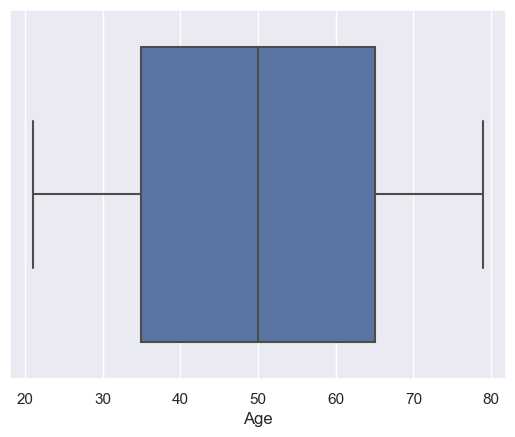

In [23]:
sns.boxplot(x='Age', data=df)
plt.show()

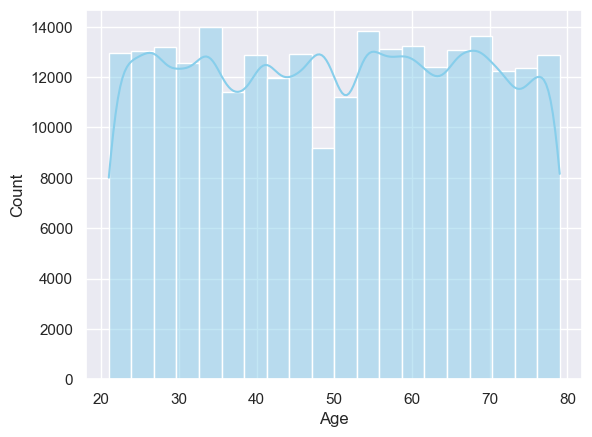

In [24]:
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.show()

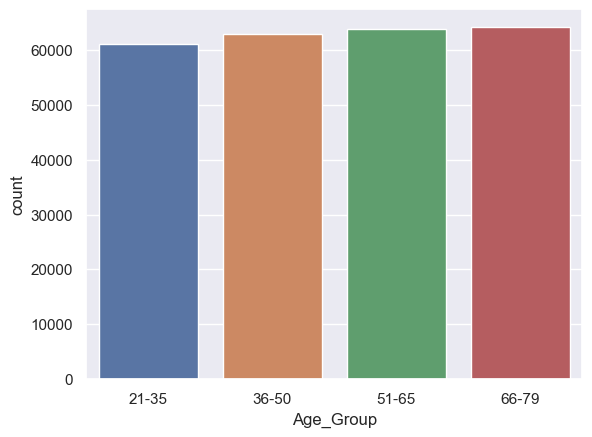

In [25]:
sns.countplot(x='Age_Group', data=df)
plt.show()

### Kolom Income

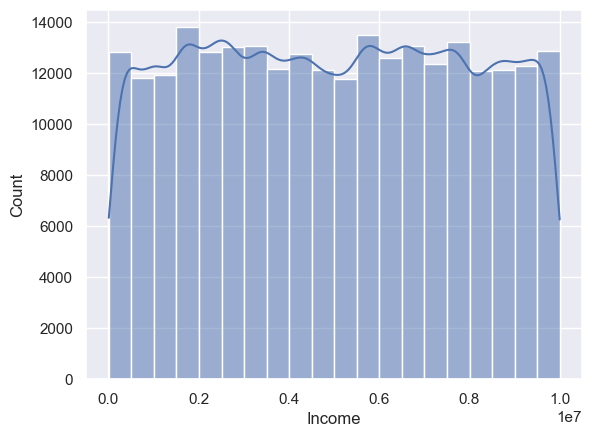

In [30]:
sns.histplot(df['Income'], kde=True, bins=20)
plt.show()

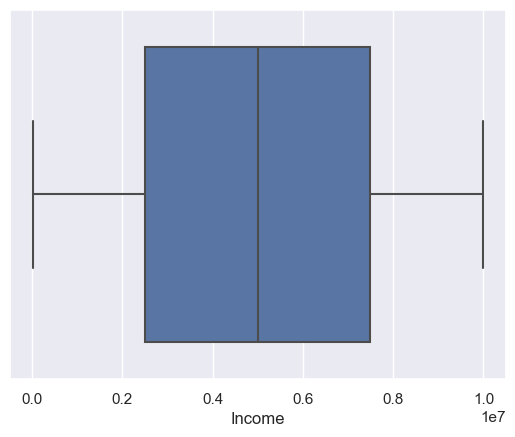

In [31]:
sns.boxplot(x='Income', data=df)
plt.show()

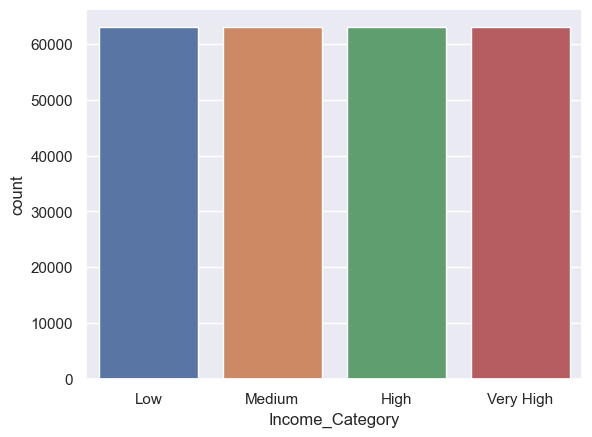

In [32]:
sns.countplot(x='Income_Category', data=df)
plt.show()

### Kolom Experience

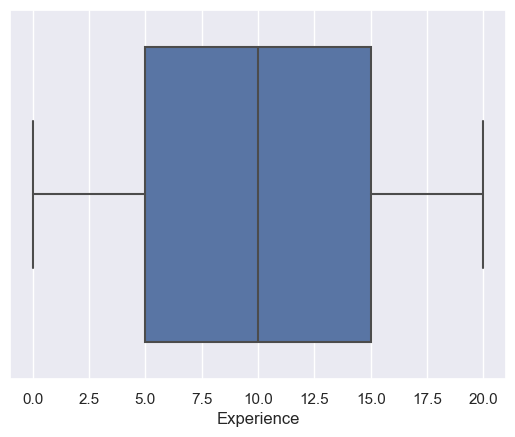

In [29]:
sns.boxplot(x='Experience', data=df)
plt.show()

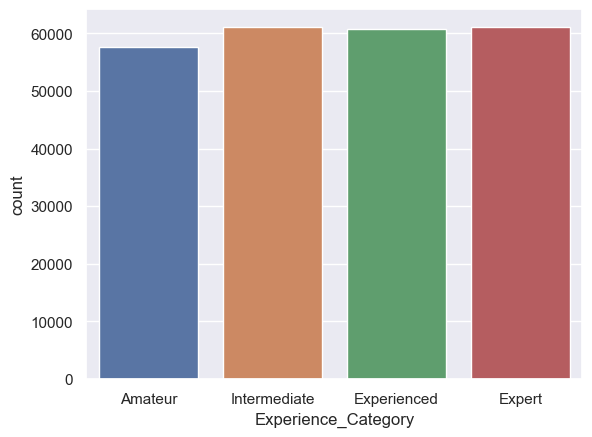

In [46]:
sns.countplot(x='Experience_Category', data=df)
plt.show()

### Kolom Married/Single

In [32]:
df['Married/Single'].value_counts(normalize=True)

Married/Single
single     0.897905
married    0.102095
Name: proportion, dtype: float64

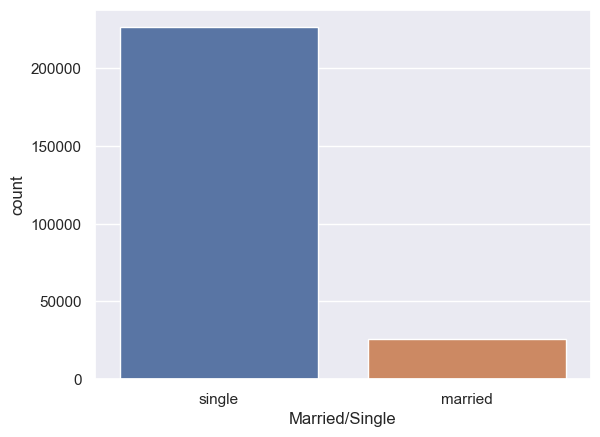

In [31]:
sns.countplot(x='Married/Single', data=df)
plt.show()

### Kolom House Ownership

In [33]:
df['House_Ownership'].value_counts(normalize=True)

House_Ownership
rented          0.920230
owned           0.051262
norent_noown    0.028508
Name: proportion, dtype: float64

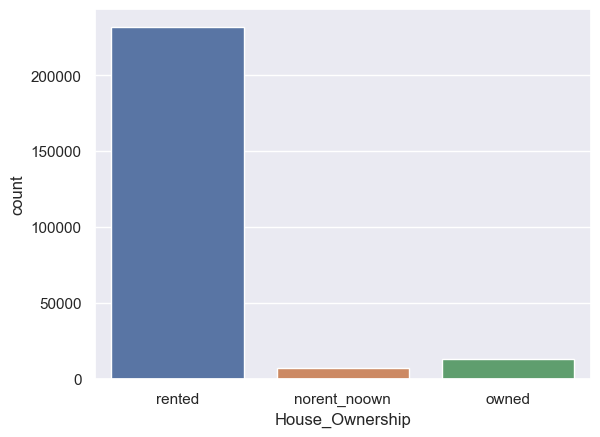

In [35]:
sns.countplot(x='House_Ownership', data=df)
plt.show()

### Kolom Car Ownership

In [36]:
df['Car_Ownership'].value_counts(normalize=True)

Car_Ownership
no     0.698413
yes    0.301587
Name: proportion, dtype: float64

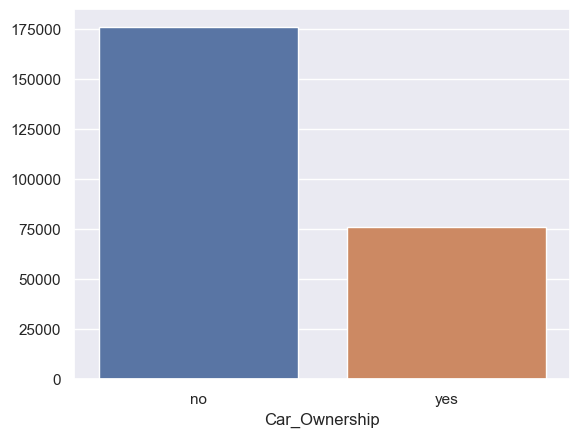

In [39]:
car_ownership_counts = df['Car_Ownership'].value_counts()

sns.barplot(x=car_ownership_counts.index, y=car_ownership_counts.values)
plt.show()

### Kolom City

In [41]:
df['CITY'].value_counts().sort_values(ascending=False).head()

CITY
Aurangabad       1543
Vijayanagaram    1259
Bhopal           1208
Bulandshahr      1185
Saharsa          1180
Name: count, dtype: int64

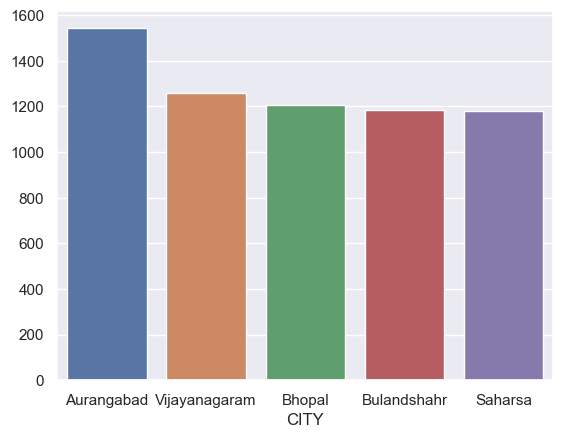

In [42]:
top_cities = df['CITY'].value_counts().sort_values(ascending=False).head()

sns.barplot(x=top_cities.index, y=top_cities.values)
plt.show()

### Kolom State

In [46]:
df['STATE'].value_counts().sort_values(ascending=False).head()

STATE
Uttar_Pradesh     28400
Maharashtra       25562
Andhra_Pradesh    25297
West_Bengal       23483
Bihar             19780
Name: count, dtype: int64

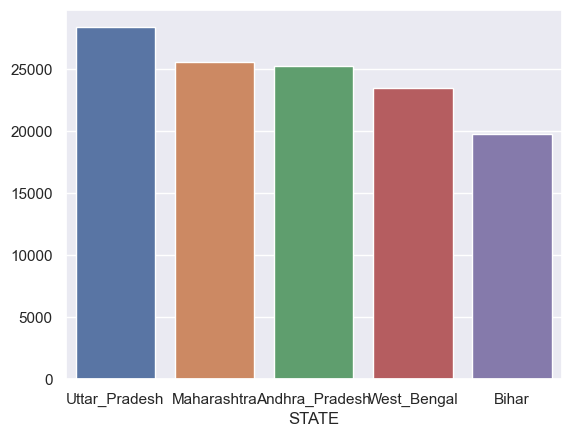

In [47]:
top_states = df['STATE'].value_counts().sort_values(ascending=False).head()

sns.barplot(x=top_states.index, y=top_states.values)
plt.show()

### Kolom Current Job Years

In [48]:
df['CURRENT_JOB_YRS'].value_counts().sort_values(ascending=False).head()

CURRENT_JOB_YRS
3    29460
4    28339
5    25091
6    23491
7    19925
Name: count, dtype: int64

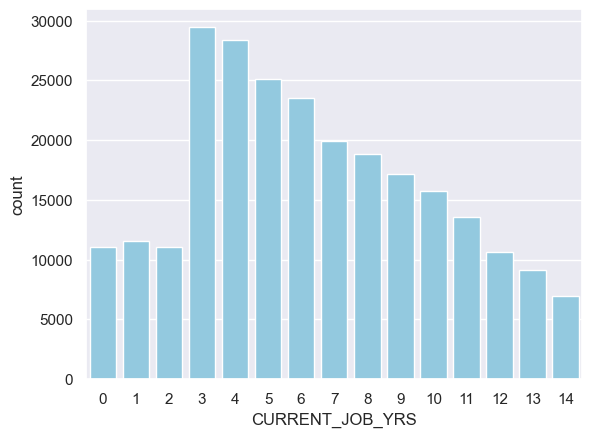

In [50]:
sns.countplot(x = 'CURRENT_JOB_YRS', data = df, color='skyblue')
plt.show()

### Kolom Current House Years

In [52]:
df['CURRENT_HOUSE_YRS'].value_counts().sort_values(ascending=False)

CURRENT_HOUSE_YRS
11    51873
12    51791
13    50659
14    49003
10    48674
Name: count, dtype: int64

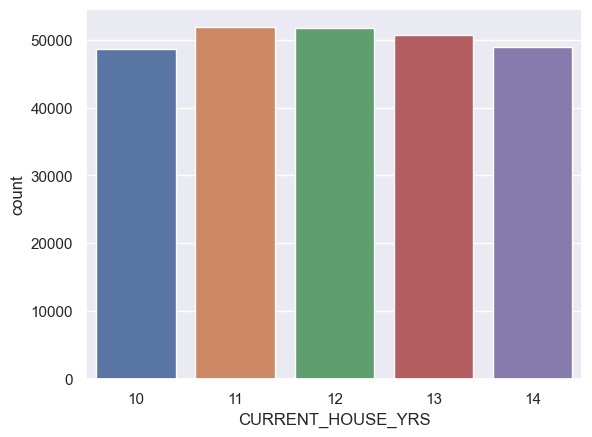

In [51]:
sns.countplot(x = 'CURRENT_HOUSE_YRS', data = df)
plt.show()

### Kolom Risk Flag

In [54]:
df['Risk_Flag'].value_counts()

Risk_Flag
0    221004
1     30996
Name: count, dtype: int64

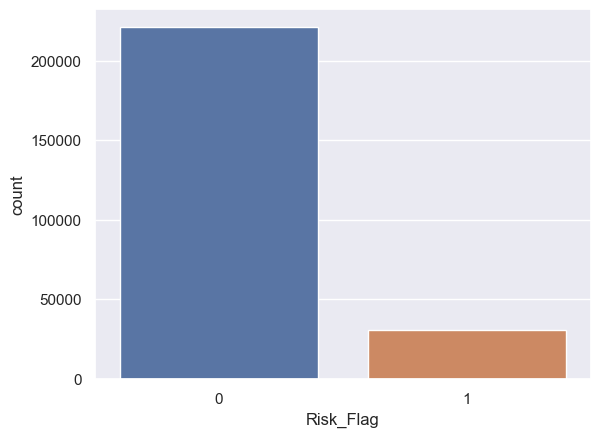

In [53]:
sns.countplot(x = 'Risk_Flag', data = df)
plt.show()

In [68]:
df['Risk_Flag'].value_counts(normalize=True)

Risk_Flag
0    0.877
1    0.123
Name: proportion, dtype: float64

### <font color = 'darkgreen'> 2. Multivariate Analysis </font>

### Numeric Columns

In [62]:
numeric_cols.corr()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Married_Single_Encode,Car_Ownership_Encode,House_Ownership_Encode,Profession_Encode,CITY_Encode,STATE_Encode,Age_Group_Encode,Income_Category_Enocode,Experience_Category_Encode,profession_map_encode,Zone_Encode
Id,1.000000,-0.001324,-0.001816,-0.005810,-0.003250,0.001972,0.032153,0.001134,-0.004313,-0.002583,-0.005734,-0.000972,0.002012,-0.001807,0.002049,-0.003012,0.000927,-0.000193
Income,-0.001324,1.000000,-0.000652,0.006422,0.007045,-0.002397,-0.003091,0.002682,0.004068,0.016433,0.000725,-0.001919,-0.004067,0.001726,0.384939,-0.010286,-0.009928,0.001970
Age,-0.001816,-0.000652,1.000000,-0.001118,0.002154,-0.020134,-0.021809,-0.005323,0.009395,-0.009820,-0.008551,0.002104,-0.004985,0.968463,0.015121,0.001699,-0.002052,0.003977
Experience,-0.005810,0.006422,-0.001118,1.000000,0.646098,0.019309,-0.034523,-0.001752,0.007519,-0.007912,0.000975,-0.025703,-0.001251,0.001440,0.010956,0.465491,0.011529,-0.015412
CURRENT_JOB_YRS,-0.003250,0.007045,0.002154,0.646098,1.000000,0.005372,-0.016942,0.004251,0.011099,-0.009790,-0.004536,-0.027353,0.008745,0.004305,0.011632,0.370143,0.006874,-0.002680
CURRENT_HOUSE_YRS,0.001972,-0.002397,-0.020134,0.019309,0.005372,1.000000,-0.004375,-0.007539,0.000251,-0.005618,0.001954,-0.010654,0.007281,-0.015790,0.006404,0.007729,0.019433,-0.008859
Risk_Flag,0.032153,-0.003091,-0.021809,-0.034523,-0.016942,-0.004375,1.000000,0.021092,-0.024036,0.023622,-0.004900,0.004575,-0.003401,-0.020448,0.004925,-0.023445,0.004930,-0.024348
Married_Single_Encode,0.001134,0.002682,-0.005323,-0.001752,0.004251,-0.007539,0.021092,1.000000,0.001206,-0.022501,-0.007534,0.012280,-0.009477,-0.003982,0.003581,-0.000884,0.012256,-0.007864
Car_Ownership_Encode,-0.004313,0.004068,0.009395,0.007519,0.011099,0.000251,-0.024036,0.001206,1.000000,-0.001233,0.011887,0.001648,0.026000,0.006461,0.014261,0.007310,0.006678,0.007087
House_Ownership_Encode,-0.002583,0.016433,-0.009820,-0.007912,-0.009790,-0.005618,0.023622,-0.022501,-0.001233,1.000000,0.001242,-0.014447,-0.007792,-0.010264,0.005333,0.006952,0.009295,0.004005


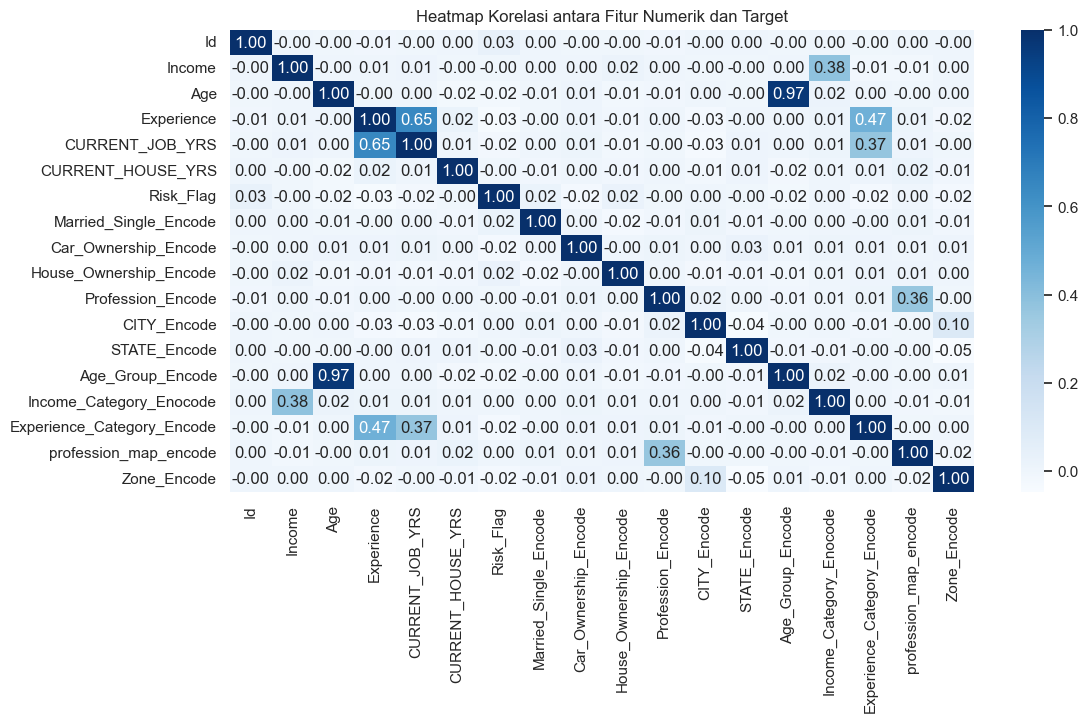

In [64]:
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Heatmap Korelasi antara Fitur Numerik dan Target', fontsize=12)
plt.show()

Dari hasil ini, tidak ada fitur numerik yang memiliki korelasi yang signifikan dengan target `Risk_Flag`.

### Categorical Columns

### Kolom 'Age_Group' VS 'Risk_Flag'

In [123]:
age_grouped = df.groupby(['Age_Group', 'Risk_Flag']).size().unstack()
age_grouped['pcg'] = (age_grouped[1] / age_grouped.sum(axis=1)) * 100
age_grouped.sort_values(by='pcg', ascending=False)

Risk_Flag,0,1,pcg
Age_Group,,,
21-35,52663,8420,13.784523
51-65,56192,7592,11.902672
36-50,55489,7452,11.839659
66-79,56660,7532,11.733549


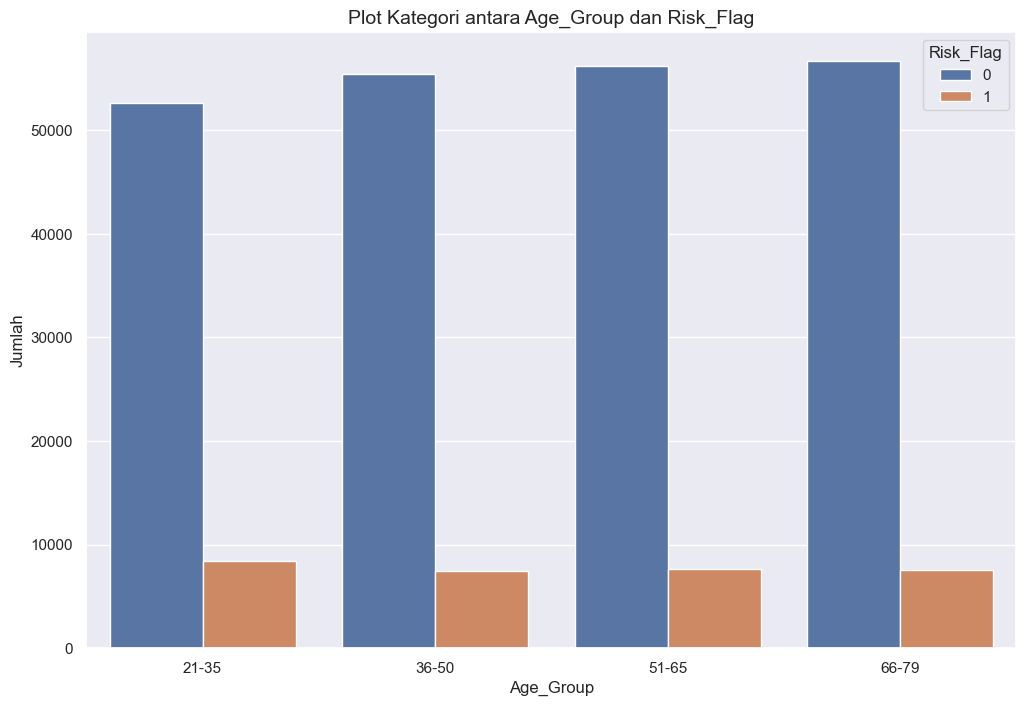

In [127]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Age_Group', hue='Risk_Flag', data=df[df['Age_Group'].isin(age_grouped.index)])
plt.title('Plot Kategori antara Age_Group dan Risk_Flag', fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Age_Group', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

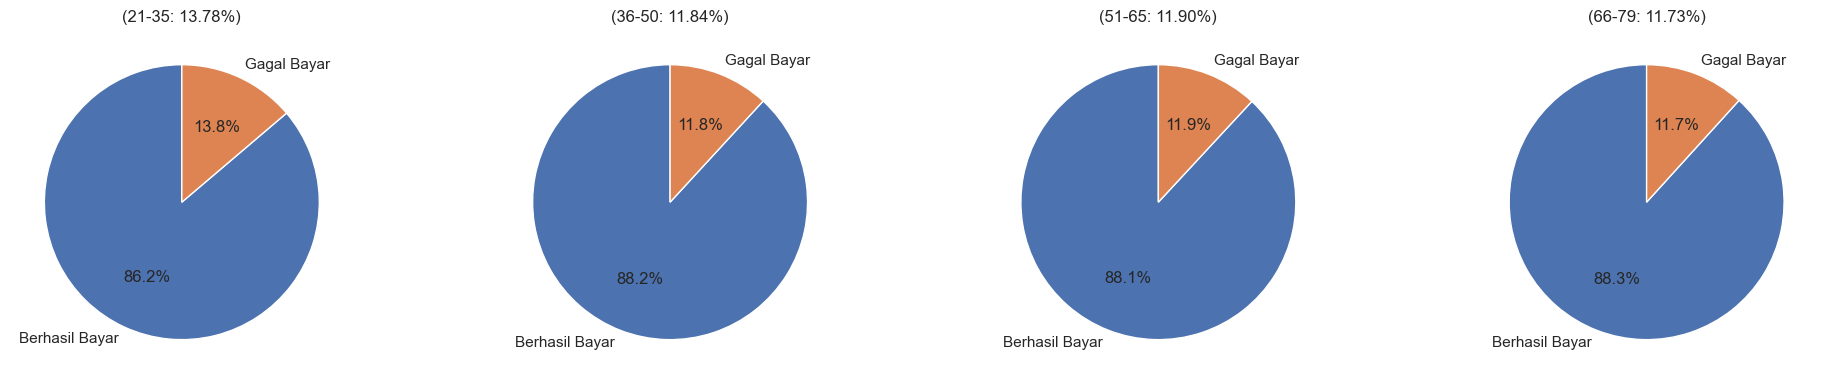

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

for i, age in enumerate(age_grouped.index):
    axes[i].pie(age_grouped.loc[age, [0, 1]], labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'({age}: {age_grouped["pcg"][age]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

### Kolom 'Experience_Category' VS 'Risk_Flag'

In [131]:
exp_grouped = df.groupby(['Experience_Category', 'Risk_Flag']).size().unstack()
exp_grouped['pcg'] = (exp_grouped[1] / exp_grouped.sum(axis=1)) * 100
exp_grouped.sort_values(by='pcg', ascending=False)

Risk_Flag,0,1,pcg
Experience_Category,,,
Amateur,49272,8309,14.430107
Intermediate,53799,7318,11.973755
Expert,53971,7147,11.693773
Experienced,53896,6938,11.404807


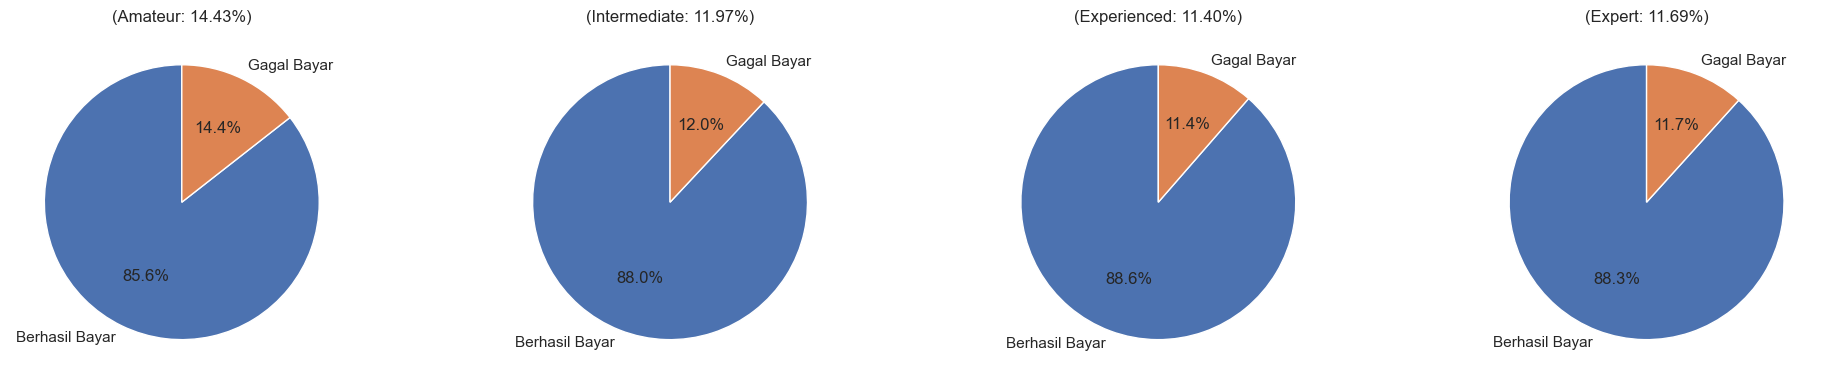

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

for i, exp in enumerate(exp_grouped.index):
    axes[i].pie(exp_grouped.loc[exp, [0, 1]], labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'({exp}: {exp_grouped["pcg"][exp]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

### Kolom 'Income_Category' VS 'Risk_Flag'

In [134]:
inc_grouped = df.groupby(['Income_Category', 'Risk_Flag']).size().unstack()
inc_grouped['pcg'] = (inc_grouped[1] / inc_grouped.sum(axis=1)) * 100
inc_grouped.sort_values(by='pcg', ascending=False)

Risk_Flag,0,1,pcg
Income_Category,,,
Low,54905,8059,12.799377
Very High,55030,7958,12.634153
Medium,55486,7513,11.925586
High,55546,7466,11.848537


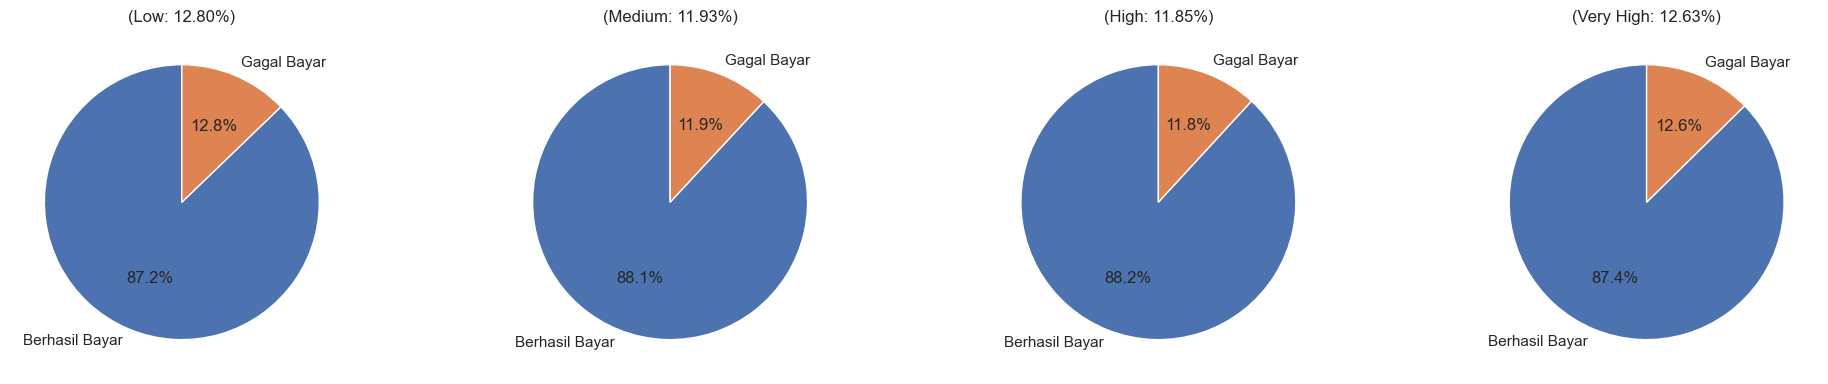

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

for i, inc in enumerate(inc_grouped.index):
    axes[i].pie(inc_grouped.loc[inc, [0, 1]], labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'({inc}: {inc_grouped["pcg"][inc]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

### Kolom 'Married/Single' VS 'Risk_Flag'

In [67]:
status_grouped = df.groupby(['Married/Single', 'Risk_Flag']).size().unstack()
status_grouped['pcg'] = (status_grouped[1] / status_grouped.sum(axis=1)) * 100
status_grouped.sort_values(by='pcg', ascending=False)

Risk_Flag,0,1,pcg
Married/Single,,,
single,197912,28360,12.533588
married,23092,2636,10.245647


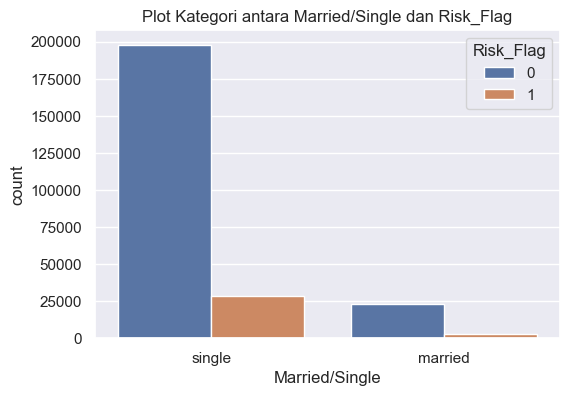

In [68]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Married/Single', hue='Risk_Flag', data=df)
plt.title('Plot Kategori antara Married/Single dan Risk_Flag', fontsize=12)
plt.xticks(rotation=0)
plt.show()

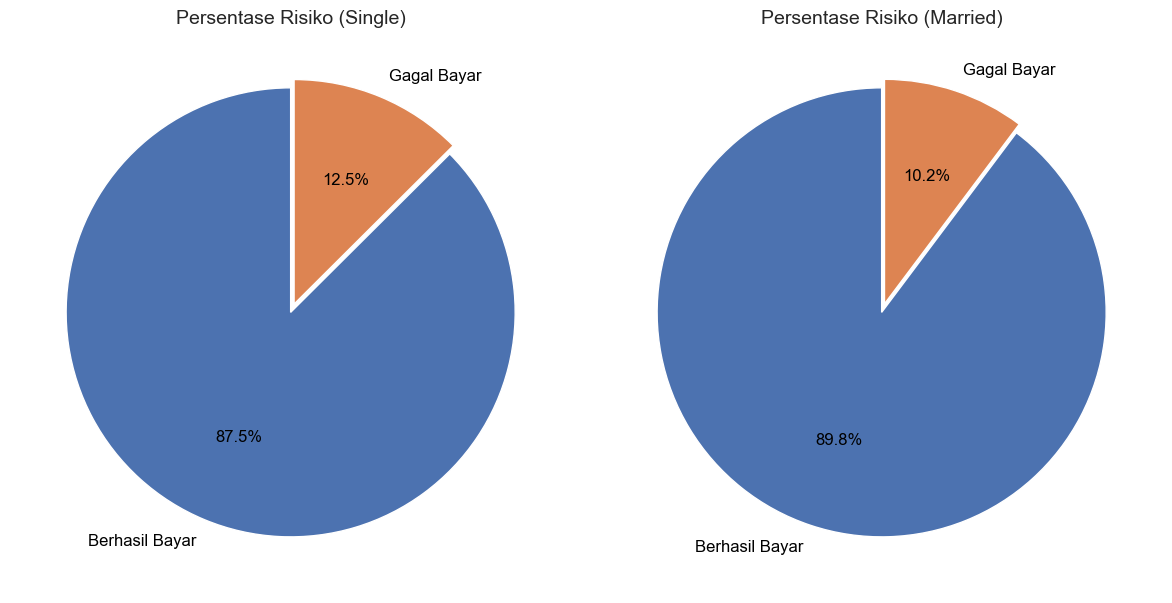

In [71]:
single_data = status_grouped.loc['single']
single_labels = ['Berhasil Bayar', 'Gagal Bayar']
single_sizes = [single_data[0], single_data[1]]

married_data = status_grouped.loc['married']
married_labels = ['Berhasil Bayar', 'Gagal Bayar']
married_sizes = [married_data[0], married_data[1]]

pie_explode = (0, 0.04) 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].pie(single_sizes, labels=single_labels, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize':12, 'color':'black'}, explode=pie_explode)
axes[0].set_title('Persentase Risiko (Single)', fontsize=14)

axes[1].pie(married_sizes, labels=married_labels, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize':12, 'color':'black'}, explode=pie_explode)
axes[1].set_title('Persentase Risiko (Married)', fontsize=14)

plt.tight_layout()
plt.show()

### Kolom 'House_Ownership' VS 'Risk_Flag'

In [94]:
house_grouped = df.groupby(['House_Ownership', 'Risk_Flag']).size().unstack()
house_grouped['pcg'] = (house_grouped[1] / house_grouped.sum(axis=1)) * 100
house_grouped.sort_values(by='pcg', ascending=False)

Risk_Flag,0,1,pcg
House_Ownership,,,
rented,202777,29121,12.557676
norent_noown,6469,715,9.952673
owned,11758,1160,8.979718


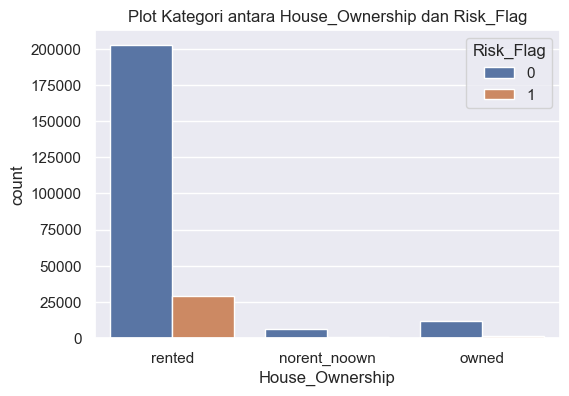

In [95]:
# Plot untuk kolom 'House_Ownership'
plt.figure(figsize=(6, 4))
sns.countplot(x='House_Ownership', hue='Risk_Flag', data=df)
plt.title('Plot Kategori antara House_Ownership dan Risk_Flag', fontsize=12)
plt.xticks(rotation=0)
plt.show()

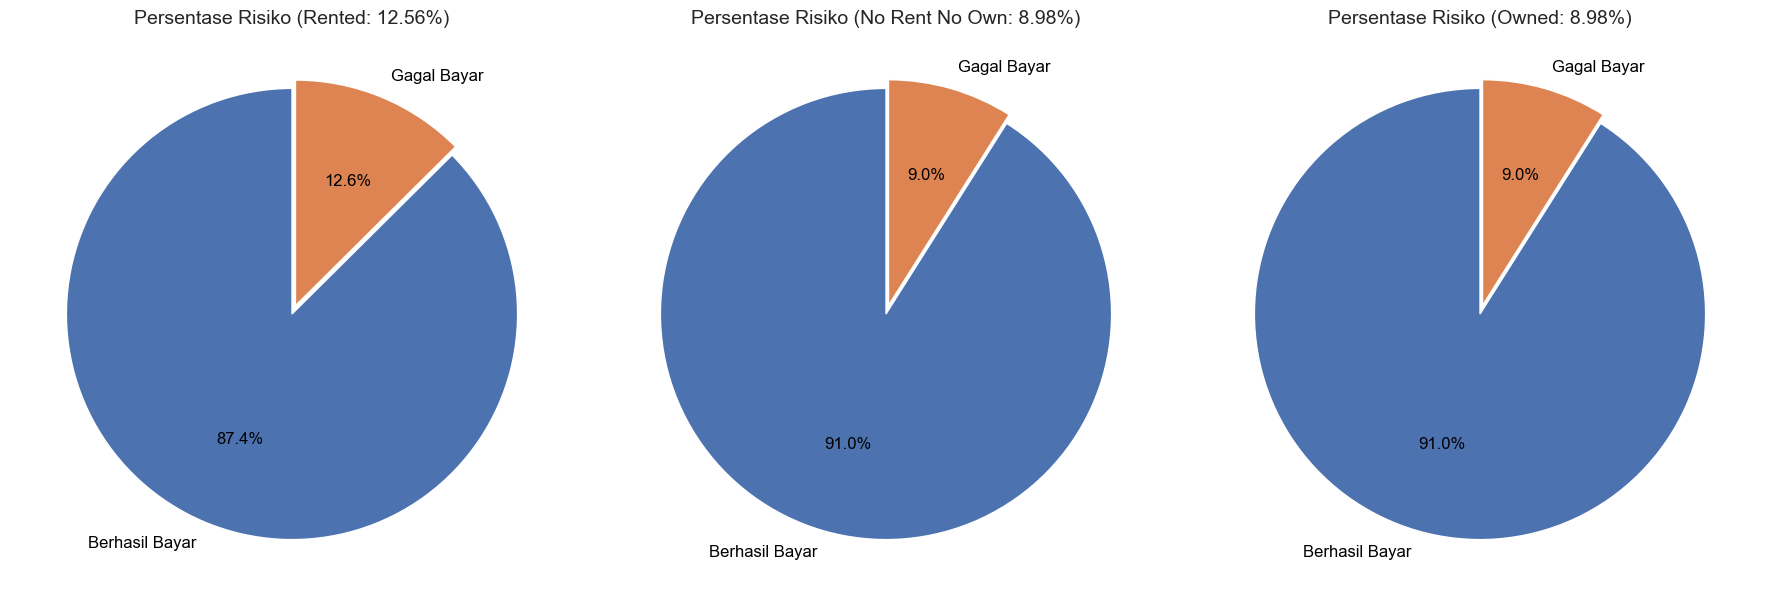

In [96]:
rented_data = house_grouped.loc['rented']
rented_labels = ['Berhasil Bayar', 'Gagal Bayar']
rented_sizes = [rented_data[0], rented_data[1]]
rented_pcg = rented_data['pcg']

owned_data = house_grouped.loc['norent_noown']
owned_labels = ['Berhasil Bayar', 'Gagal Bayar']
owned_sizes = [owned_data[0], owned_data[1]]
owned_pcg = owned_data['pcg']

owned_data = house_grouped.loc['owned']
owned_labels = ['Berhasil Bayar', 'Gagal Bayar']
owned_sizes = [owned_data[0], owned_data[1]]
owned_pcg = owned_data['pcg']

pie_explode = (0, 0.04)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].pie(rented_sizes, labels=rented_labels, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize':12, 'color':'black'}, explode=pie_explode)
axes[0].set_title(f'Persentase Risiko (Rented: {rented_pcg:.2f}%)', fontsize=14)

axes[1].pie(owned_sizes, labels=owned_labels, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize':12, 'color':'black'}, explode=pie_explode)
axes[1].set_title(f'Persentase Risiko (No Rent No Own: {owned_pcg:.2f}%)', fontsize=14)

axes[2].pie(owned_sizes, labels=owned_labels, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize':12, 'color':'black'}, explode=pie_explode)
axes[2].set_title(f'Persentase Risiko (Owned: {owned_pcg:.2f}%)', fontsize=14)

plt.tight_layout()
plt.show()

### Kolom 'Profession' VS 'Risk_Flag'

#### Profession By Grouped

In [72]:
profession_map_grouped = df.groupby(['profession_map', 'Risk_Flag']).size().unstack()
profession_map_grouped['pcg'] = (profession_map_grouped[1] / profession_map_grouped.sum(axis=1)) * 100
profession_map_grouped = profession_map_grouped.sort_values(by='pcg', ascending=False).head(10)
profession_map_grouped

Risk_Flag,0,1,pcg
profession_map,,,
Government,24698,3799,13.331228
Aviation,13176,1991,13.127184
Science/Research,25839,3833,12.917902
Hospitality,8549,1264,12.880872
Administration,8772,1279,12.725102
IT/Software,18179,2632,12.647158
Other,20619,2921,12.408666
Art,8895,1225,12.104743
Design,12834,1725,11.848341


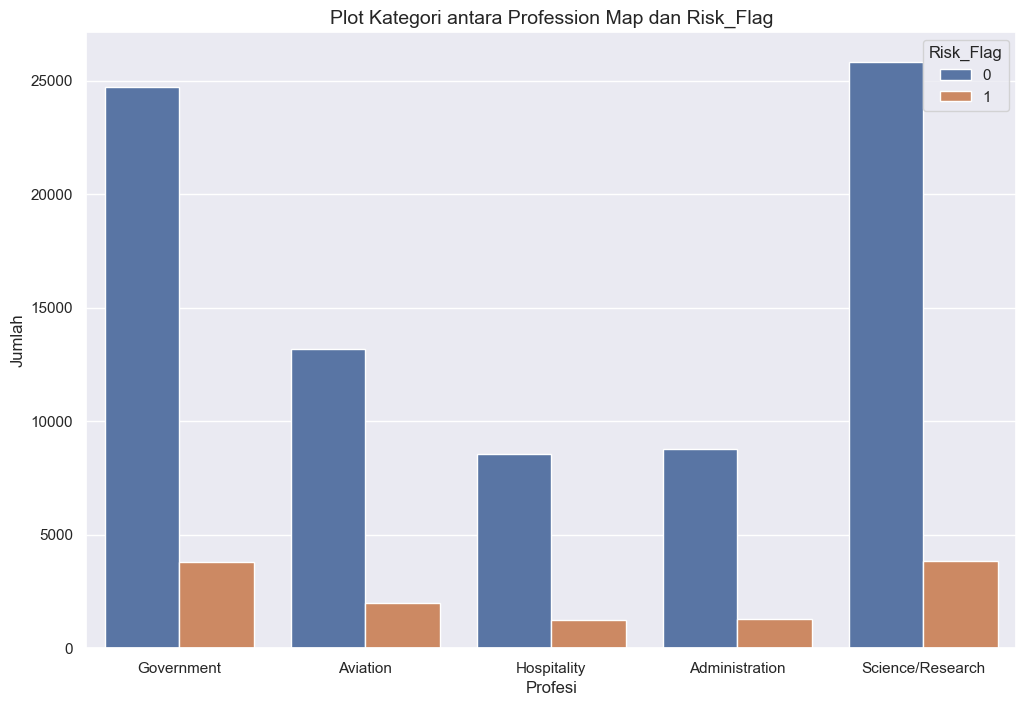

In [73]:
top_profession_maps = profession_map_grouped.sort_values(by='pcg', ascending=False).head(5)

plt.figure(figsize=(12, 8))
sns.countplot(x='profession_map', hue='Risk_Flag', data=df[df['profession_map'].isin(top_profession_maps.index)])
plt.title('Plot Kategori antara Profession Map dan Risk_Flag', fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Profesi', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

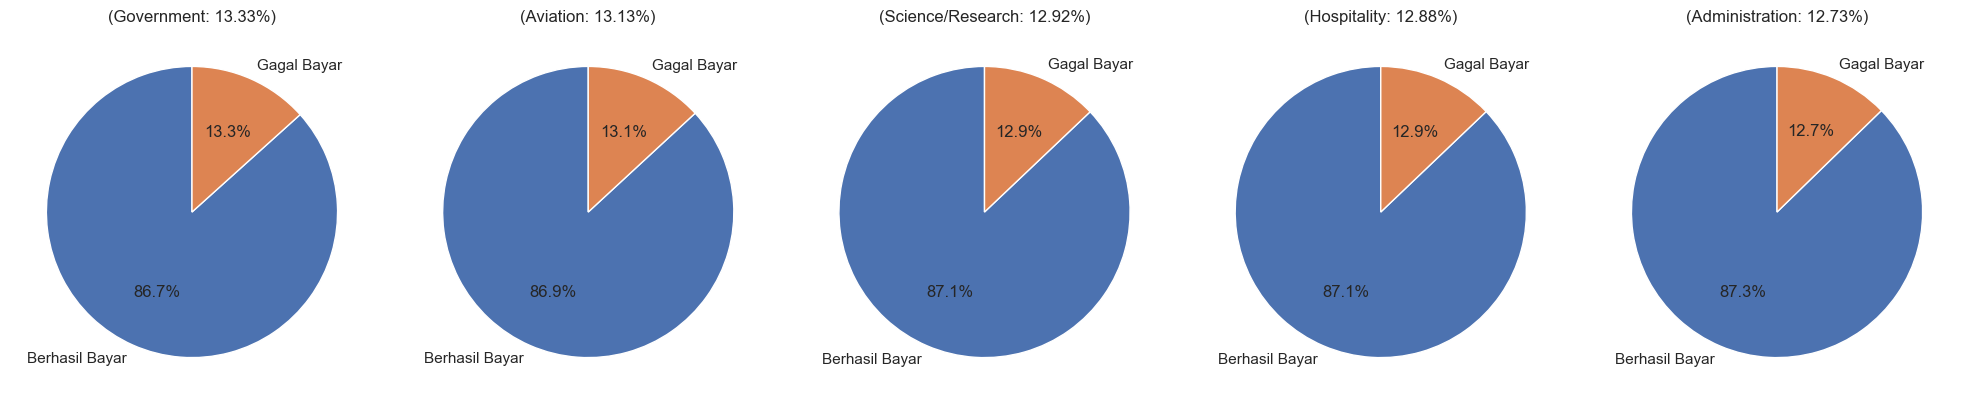

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

for i, profession in enumerate(top_profession_maps.index):
    axes[i].pie(top_profession_maps.loc[profession, [0, 1]], labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'({profession}: {top_profession_maps["pcg"][profession]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

#### Profession By Specific

In [75]:
profession_grouped = df.groupby(['Profession', 'Risk_Flag']).size().unstack()
profession_grouped['pcg'] = (profession_grouped[1] / profession_grouped.sum(axis=1)) * 100
profession_grouped.sort_values(by='pcg', ascending=False).head()

Risk_Flag,0,1,pcg
Profession,,,
Police_officer,4209,826,16.405164
Chartered_Accountant,3803,690,15.357222
Army_officer,3952,709,15.211328
Surveyor,4000,714,15.146373
Software_Developer,4303,750,14.842668


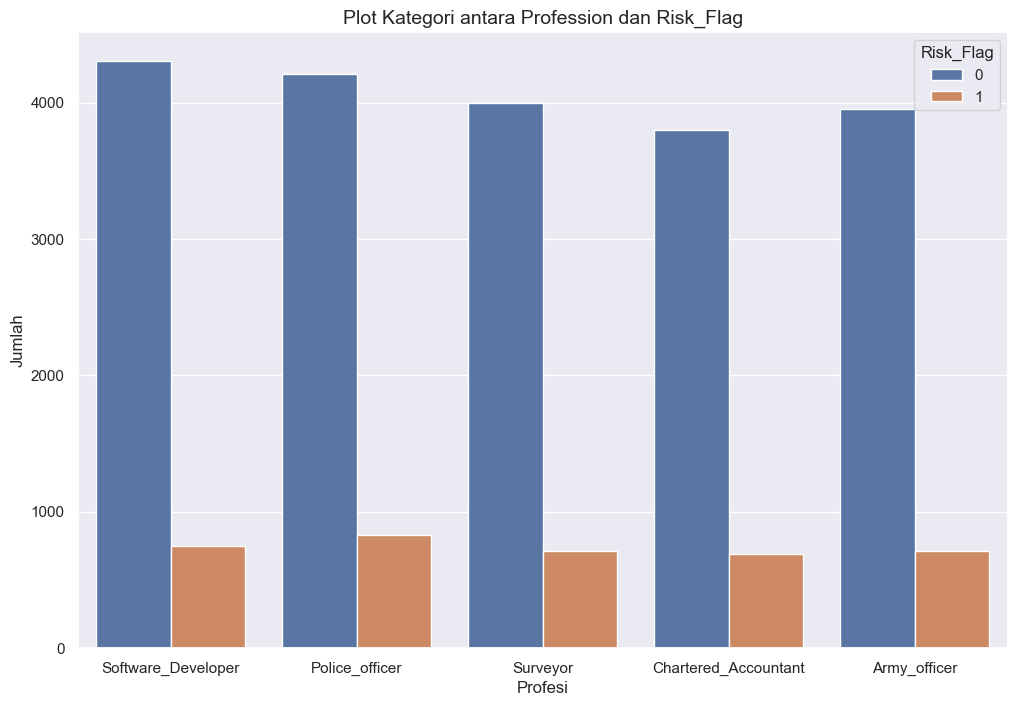

In [76]:
top_professions = profession_grouped.sort_values(by='pcg', ascending=False).head(5)

plt.figure(figsize=(12, 8))
sns.countplot(x='Profession', hue='Risk_Flag', data=df[df['Profession'].isin(top_professions.index)])
plt.title('Plot Kategori antara Profession dan Risk_Flag', fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Profesi', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

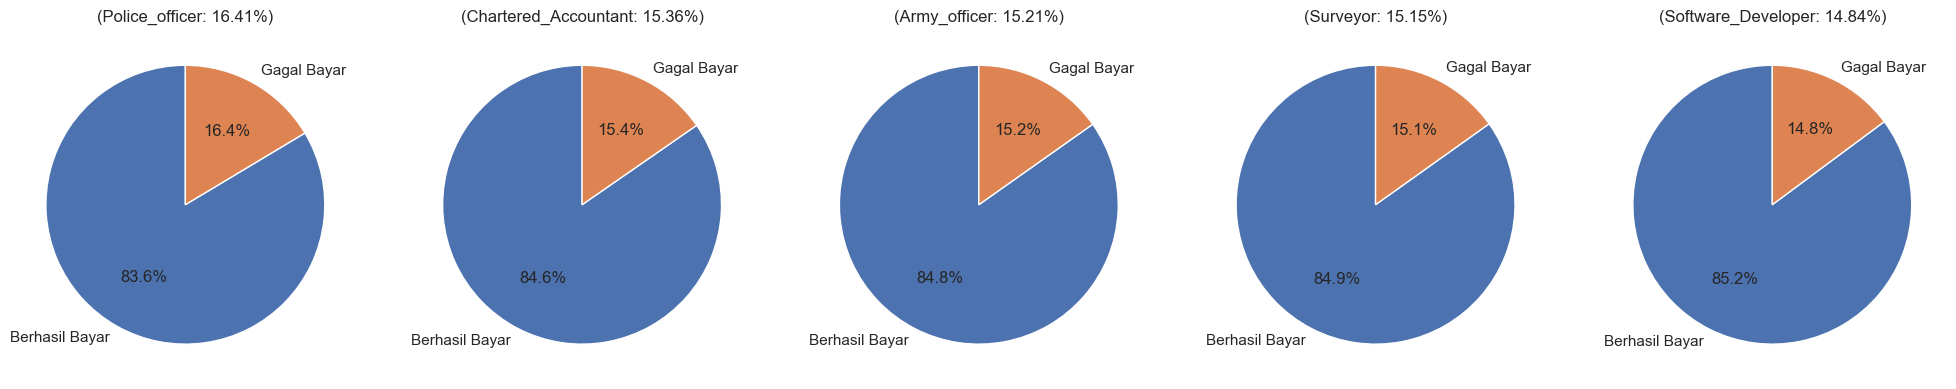

In [77]:
top_professions = profession_grouped.sort_values(by='pcg', ascending=False).head(5)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

for i, profession in enumerate(top_professions.index):
    axes[i].pie(top_professions.loc[profession, [0, 1]], labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'({profession}: {top_professions["pcg"][profession]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

### Kolom 'CITY' VS 'Risk_Flag'

In [20]:
city_grouped = df.groupby(['CITY', 'Risk_Flag']).size().unstack()
city_grouped['pcg'] = (city_grouped[1] / city_grouped.sum(axis=1)) * 100
top_cities = city_grouped.sort_values(by='pcg', ascending=False).head()
top_cities

Risk_Flag,0,1,pcg
CITY,,,
Bhubaneswar,409,198,32.619440
Gwalior,448,168,27.272727
Bettiah,335,122,26.695842
Kochi,718,243,25.286160
Raiganj,546,172,23.955432


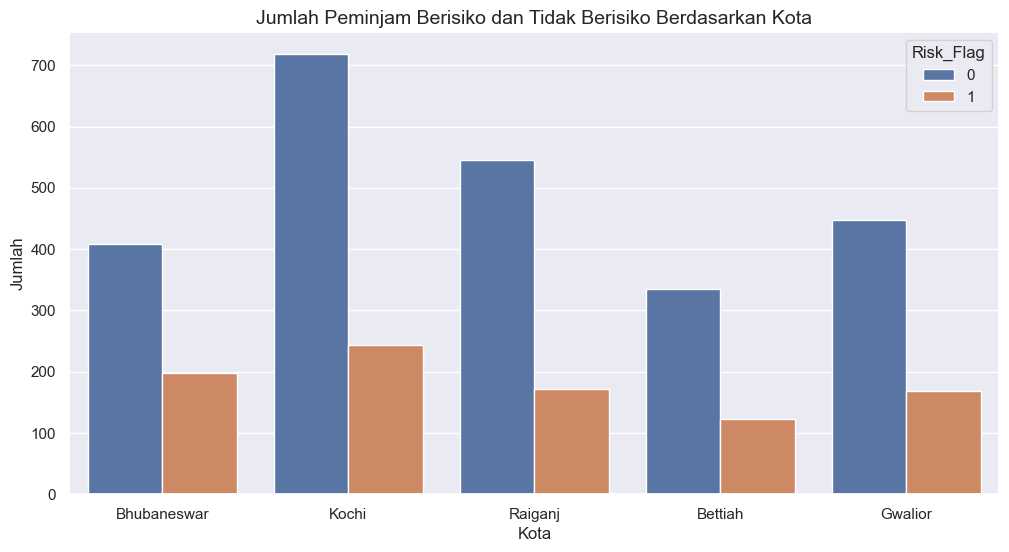

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['CITY'].isin(top_cities.index)], x='CITY', hue='Risk_Flag')
plt.title('Jumlah Peminjam Berisiko dan Tidak Berisiko Berdasarkan Kota', fontsize=14)
plt.xlabel('Kota', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

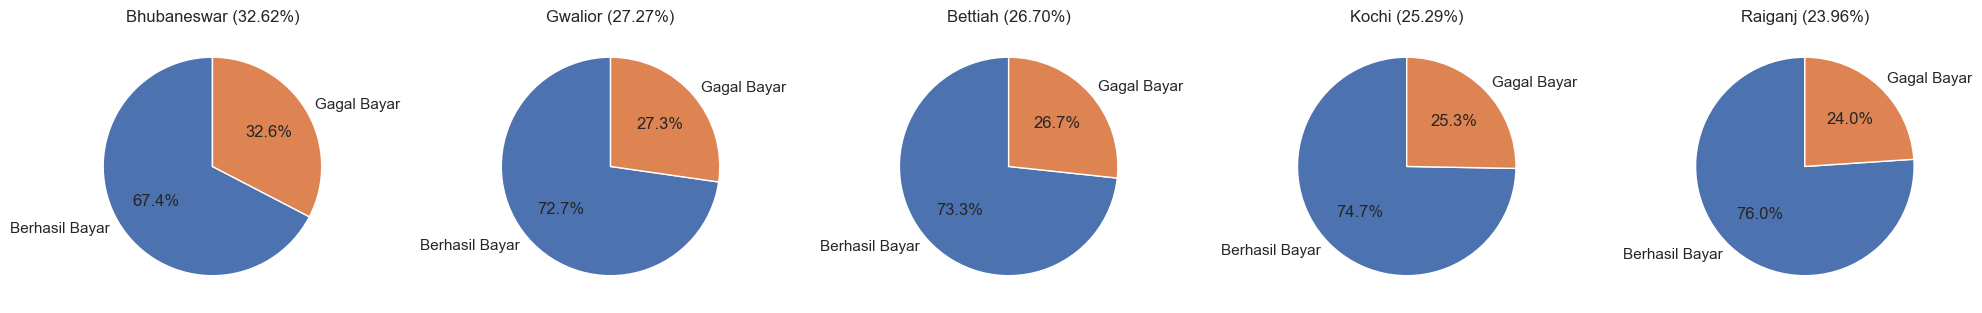

In [22]:
# Membuat subplot untuk pie chart
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# Membuat pie chart untuk setiap kota teratas
for i, city in enumerate(top_cities.index):
    sizes = top_cities.loc[city, [0, 1]]
    axes[i].pie(sizes, labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{city} ({top_cities["pcg"][city]:.2f}%)', fontsize=12)

# Menampilkan plot pie chart
plt.tight_layout()
plt.show()

### Kolom 'State' VS 'Risk_Flag'

#### State By Grouped

In [83]:
zone_grouped = df.groupby(['Zone', 'Risk_Flag']).size().unstack().sort_values(by=1, ascending=False)
zone_grouped['pcg'] = (zone_grouped[1] / zone_grouped.sum(axis=1)) * 100
zone_grouped.sort_values(by='pcg', ascending=False).head()

Risk_Flag,0,1,pcg
Zone,,,
Central Zone,15265,2691,14.986634
North East Zone,8806,1371,13.471554
East Zone,49435,7451,13.098126
West Zone,40614,5530,11.984223
South Zone,60505,7946,11.608304


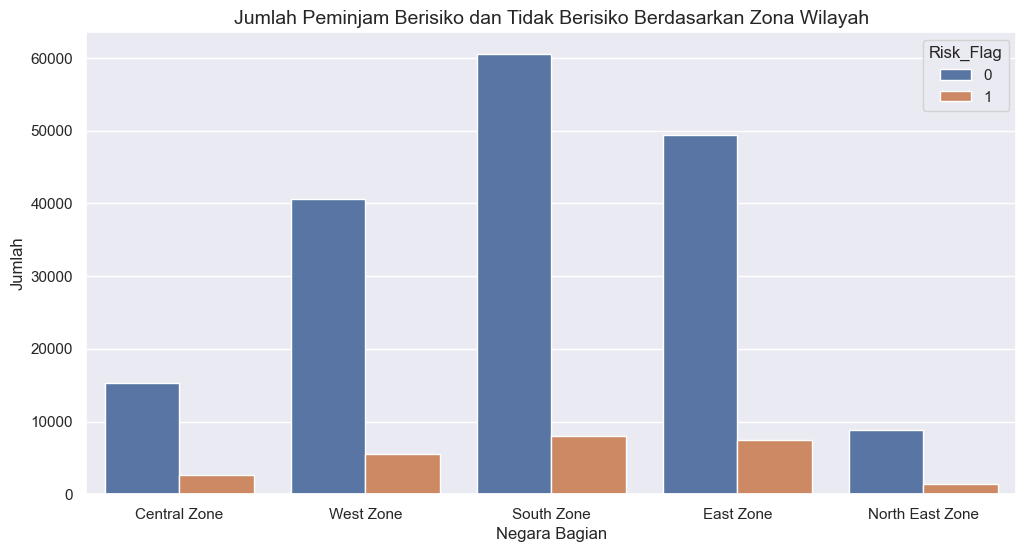

In [84]:
top_zone = zone_grouped.sort_values(by='pcg', ascending=False).head()

plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['Zone'].isin(top_zone.index)], x='Zone', hue='Risk_Flag')
plt.title('Jumlah Peminjam Berisiko dan Tidak Berisiko Berdasarkan Zona Wilayah', fontsize=14)
plt.xlabel('Negara Bagian', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

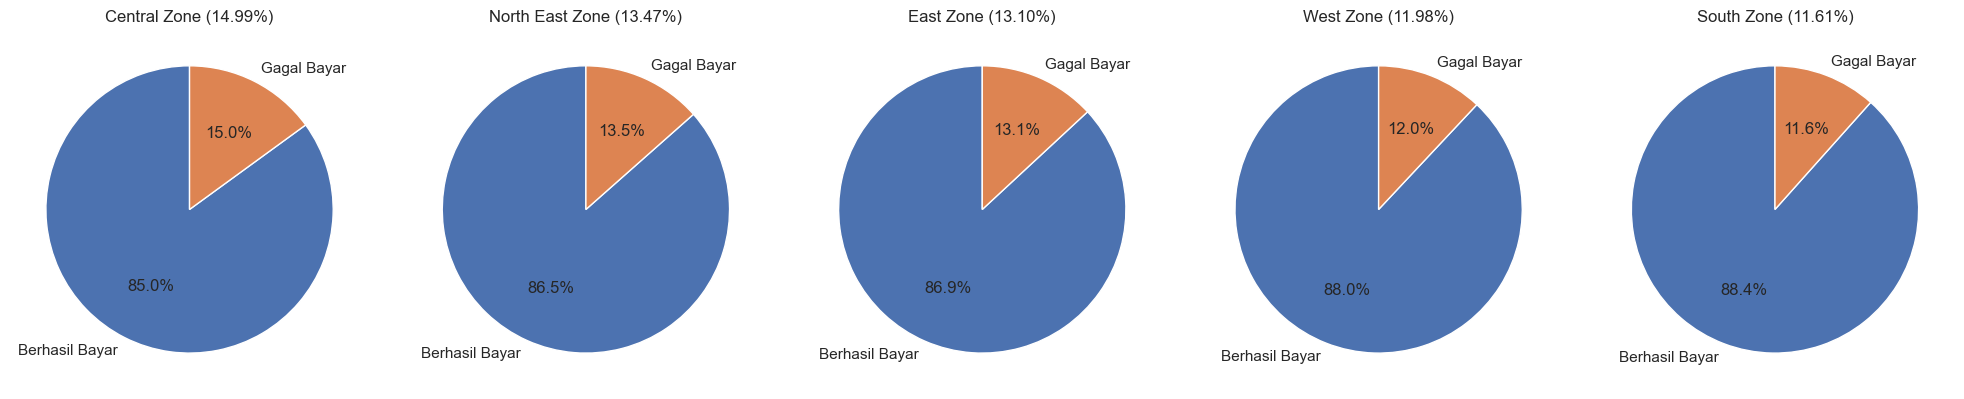

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, zone in enumerate(top_zone.index):
    sizes = top_zone.loc[zone, [0, 1]]
    axes[i].pie(sizes, labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{zone} ({top_zone["pcg"][zone]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

#### State By Specific

In [86]:
state_grouped = df.groupby(['STATE', 'Risk_Flag']).size().unstack().sort_values(by=1, ascending=False)
state_grouped['pcg'] = (state_grouped[1] / state_grouped.sum(axis=1)) * 100
state_grouped.sort_values(by='pcg', ascending=False).head()

Risk_Flag,0,1,pcg
STATE,,,
Manipur,666,183,21.554770
Tripura,673,136,16.810878
Kerala,4835,970,16.709733
Jammu_and_Kashmir,1497,283,15.898876
Madhya_Pradesh,11942,2180,15.436907


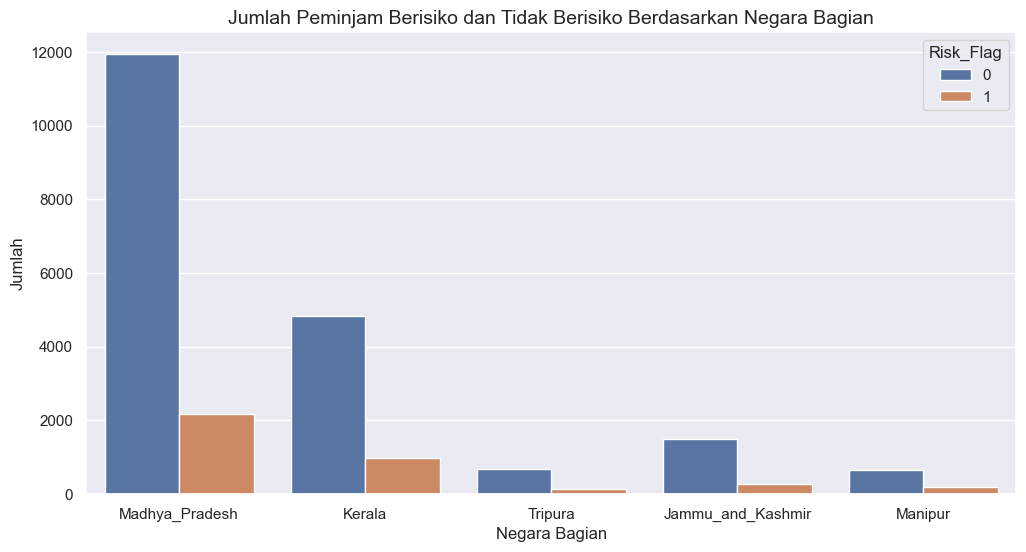

In [87]:
top_states = state_grouped.sort_values(by='pcg', ascending=False).head()

plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['STATE'].isin(top_states.index)], x='STATE', hue='Risk_Flag')
plt.title('Jumlah Peminjam Berisiko dan Tidak Berisiko Berdasarkan Negara Bagian', fontsize=14)
plt.xlabel('Negara Bagian', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Risk_Flag', loc='upper right')
plt.show()

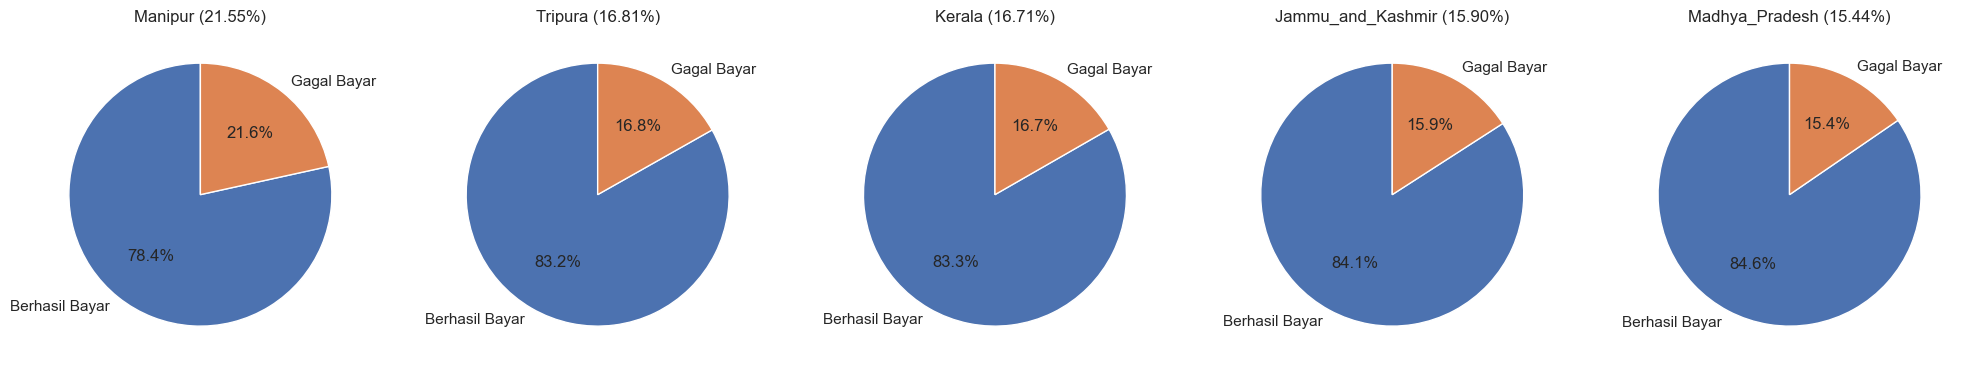

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, state in enumerate(top_states.index):
    sizes = top_states.loc[state, [0, 1]]
    axes[i].pie(sizes, labels=['Berhasil Bayar', 'Gagal Bayar'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{state} ({top_states["pcg"][state]:.2f}%)', fontsize=12)

plt.tight_layout()
plt.show()

### Uji ANOVA Test

In [90]:
for col in numeric_cols:
    if col != 'Id' and col != 'Risk_Flag':
        print(f"Uji ANOVA untuk {col}:")
        groups = [df[col][df['Risk_Flag'] == i] for i in df['Risk_Flag'].unique()]
        f_stat, p_value = f_oneway(*groups)
        print("Nilai F-statistic:", f_stat)
        print("P-value:", p_value)
        if p_value < 0.05:
            print("Terdapat perbedaan yang signifikan.")
        else:
            print("Tidak terdapat perbedaan yang signifikan.")
        print()

Uji ANOVA untuk Income:
Nilai F-statistic: 2.4079446287996715
P-value: 0.1207220319583281
Tidak terdapat perbedaan yang signifikan.

Uji ANOVA untuk Age:
Nilai F-statistic: 119.91850679948466
P-value: 6.687623647499306e-28
Terdapat perbedaan yang signifikan.

Uji ANOVA untuk Experience:
Nilai F-statistic: 300.69230651920316
P-value: 2.5475634865752383e-67
Terdapat perbedaan yang signifikan.

Uji ANOVA untuk CURRENT_JOB_YRS:
Nilai F-statistic: 72.34852624927743
P-value: 1.813221223267855e-17
Terdapat perbedaan yang signifikan.

Uji ANOVA untuk CURRENT_HOUSE_YRS:
Nilai F-statistic: 4.823851147277152
P-value: 0.02806947277438121
Terdapat perbedaan yang signifikan.

Uji ANOVA untuk Married_Single_Encode:
Nilai F-statistic: 112.15304848102096
P-value: 3.349915671513422e-26
Terdapat perbedaan yang signifikan.

Uji ANOVA untuk Car_Ownership_Encode:
Nilai F-statistic: 145.66615385165778
P-value: 1.568877481237246e-33
Terdapat perbedaan yang signifikan.

Uji ANOVA untuk House_Ownership_Encode:


### Uji Chi-Square Test

In [91]:
for col in categorical_cols:
    print(f"Uji chi-square untuk {col}:")
    contingency_table = pd.crosstab(df[col], df['Risk_Flag'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    print("Nilai chi-square statistic:", chi2_stat)
    print("P-value:", p_value)
    if p_value < 0.05:
        print("Terdapat hubungan yang signifikan antara", col, "dan Risk_Flag.")
    else:
        print("Tidak terdapat hubungan yang signifikan antara", col, "dan Risk_Flag.")
    print()

Uji chi-square untuk Married/Single:
Nilai chi-square statistic: 111.89204667099783
P-value: 3.773053705715196e-26
Terdapat hubungan yang signifikan antara Married/Single dan Risk_Flag.

Uji chi-square untuk House_Ownership:
Nilai chi-square statistic: 182.98924138871385
P-value: 1.8381930028370595e-40
Terdapat hubungan yang signifikan antara House_Ownership dan Risk_Flag.

Uji chi-square untuk Car_Ownership:
Nilai chi-square statistic: 145.42374419378916
P-value: 1.7350853850183742e-33
Terdapat hubungan yang signifikan antara Car_Ownership dan Risk_Flag.

Uji chi-square untuk Profession:
Nilai chi-square statistic: 613.4862093528226
P-value: 5.108641602000937e-98
Terdapat hubungan yang signifikan antara Profession dan Risk_Flag.

Uji chi-square untuk CITY:
Nilai chi-square statistic: 5223.113291690215
P-value: 0.0
Terdapat hubungan yang signifikan antara CITY dan Risk_Flag.

Uji chi-square untuk STATE:
Nilai chi-square statistic: 733.396800420077
P-value: 2.0057472384130266e-136
Terda

## <font color = 'green'> Feature Selection </font>

In [20]:
numeric_cols.columns

Index(['Id', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag', 'Married_Single_Encode',
       'Car_Ownership_Encode', 'House_Ownership_Encode', 'Profession_Encode',
       'CITY_Encode', 'STATE_Encode', 'Age_Group_Encode',
       'Income_Category_Enocode', 'Experience_Category_Encode',
       'profession_map_encode', 'Zone_Encode'],
      dtype='object')

Berdasarkan uji statistik, kolom `Id`, `Income`, `STATE` tidak memiliki korelasi terhadap fitur `Risk_Flag`.

In [22]:
X = numeric_cols.drop(['Id', 'Income', 'STATE_Encode', 'Risk_Flag'], axis=1)
y = numeric_cols[['Risk_Flag']]

## <font color = 'green'> Handling Imbalance Data </font>

### SMOTE

In [24]:
""" 
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

print("Distribusi Kelas setelah Oversampling:")
print(pd.Series(y_resampled.squeeze()).value_counts())
"""


' \nsmote = SMOTE(random_state=42)\n\nX_resampled, y_resampled = smote.fit_resample(X, y)\n\nprint("Distribusi Kelas setelah Oversampling:")\nprint(pd.Series(y_resampled.squeeze()).value_counts())\n'

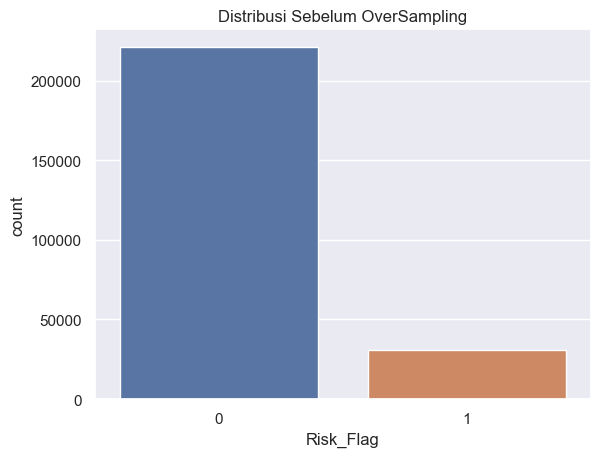

In [24]:
"""
sns.countplot(x = 'Risk_Flag', data = df)
plt.title('Distribusi Sebelum OverSampling')
plt.show()
"""

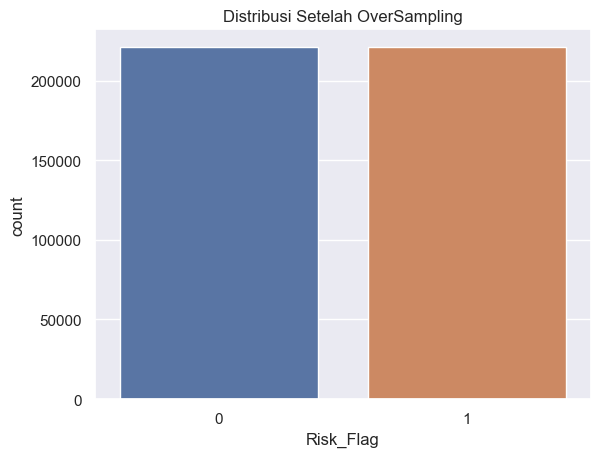

In [25]:
"""
sns.countplot(x = 'Risk_Flag', data = y_resampled)
plt.title('Distribusi Setelah OverSampling')
plt.show()
"""

In [26]:
"""
print("Sebelum oversampling:")
print(y[y['Risk_Flag'] == 1].describe())

print("\nSesudah oversampling:")
print(y_resampled[y_resampled['Risk_Flag'] == 1].describe())
"""

Sebelum oversampling:
       Risk_Flag
count    30996.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0

Sesudah oversampling:
       Risk_Flag
count   221004.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0


## <font color = 'green'> Pemodelan ML </font>

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
y_train.value_counts()

Risk_Flag
0            165796
1             23204
Name: count, dtype: int64

#### SMOTE

In [68]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#### Standarisasi

In [114]:
"""
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

### Decision Tree

In [69]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [70]:
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi model Decision Tree pada data pengujian: {:.2f}%".format(accuracy * 100))

Akurasi model Decision Tree pada data pengujian: 86.64%


In [71]:
y_train_pred = dt_model.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
print("Akurasi pada data pelatihan: {:.2f}%".format(train_accuracy * 100))

y_test_pred = dt_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Akurasi pada data pengujian: {:.2f}%".format(test_accuracy * 100))

Akurasi pada data pelatihan: 95.77%
Akurasi pada data pengujian: 86.64%


### Hypertunning Parameter

In [72]:
from sklearn.model_selection import RandomizedSearchCV
model = DecisionTreeClassifier()

In [73]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [74]:
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=42)

In [75]:
random_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='accuracy')

In [76]:
print("Parameter terbaik:", random_search.best_params_)

print("\nSkor validasi silang terbaik:", random_search.best_score_)

test_score = random_search.score(X_test, y_test)
print("\nAkurasi pada data pengujian:", test_score)

Parameter terbaik: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'entropy'}

Skor validasi silang terbaik: 0.9125311085294976

Akurasi pada data pengujian: 0.8647619047619047


### Decision Tree

In [77]:
best_params = {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 
               'max_features': 'log2', 'max_depth': 30, 'criterion': 'entropy'}
dt_classifier = DecisionTreeClassifier(**best_params)

In [78]:
cv_scores = cross_val_score(dt_classifier, X_train_resampled, y_train_resampled, cv=5)

In [79]:
dt_classifier.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='log2')

In [80]:
y_train_pred = dt_classifier.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)

In [81]:
y_pred_test = dt_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [82]:
print("Hasil Cross-Validation:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold-{i}: {score}")

Hasil Cross-Validation:
Fold-1: 0.8902275366033867
Fold-2: 0.9182888764909001
Fold-3: 0.91907174522754
Fold-4: 0.920097107874182
Fold-5: 0.9167646792725956


In [83]:
mean_cv_score = cv_scores.mean()
print(f"Rata-rata skor cross-validation: {mean_cv_score}")

Rata-rata skor cross-validation: 0.9128899890937209


In [84]:
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     55208
           1       0.48      0.85      0.61      7792

    accuracy                           0.87     63000
   macro avg       0.73      0.86      0.76     63000
weighted avg       0.91      0.87      0.88     63000



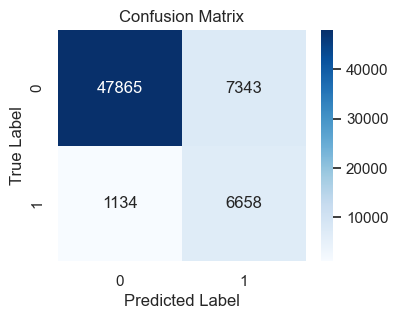

In [85]:
y_pred = dt_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [86]:
print("Akurasi pada data pelatihan:", train_accuracy)
print("\nAkurasi pada data pengujian:", test_accuracy)

Akurasi pada data pelatihan: 0.9572004149677917

Akurasi pada data pengujian: 0.8654444444444445


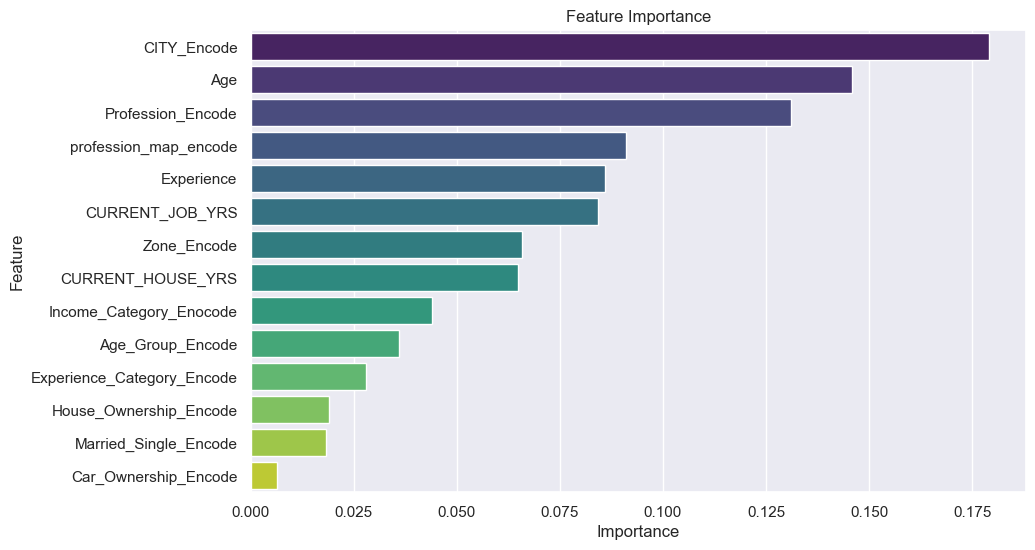

In [87]:
feature_importance = dt_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [59]:
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

train_sizes, train_scores, test_scores = learning_curve(
    dt_classifier, X_train_resampled, y_train_resampled, train_sizes=train_sizes, cv=5)

In [60]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [65]:
print('train_scores_mean', train_scores_mean, '\ntest_scores_mean', test_scores_mean)

train_scores_mean [0.96328592 0.95183988 0.94888799 0.93912813 0.95133434 0.95712866] 
test_scores_mean [0.66308065 0.72629061 0.7460611  0.8938096  0.91002101 0.91323743]


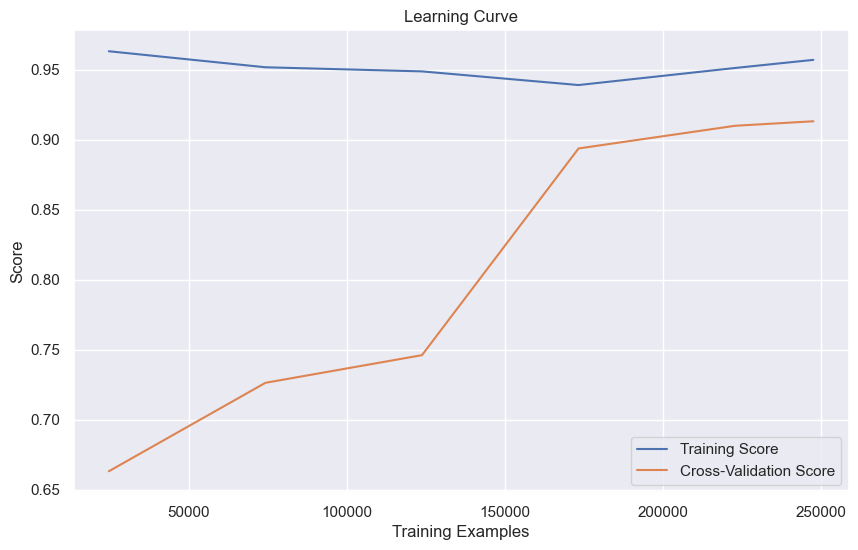

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

## No SMOTE

### DecisionTree

In [27]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [28]:
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi model Decision Tree pada data pengujian: {:.2f}%".format(accuracy * 100))

Akurasi model Decision Tree pada data pengujian: 87.99%


In [29]:
y_train_pred = dt_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Akurasi pada data pelatihan: {:.2f}%".format(train_accuracy * 100))

y_test_pred = dt_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Akurasi pada data pengujian: {:.2f}%".format(test_accuracy * 100))

Akurasi pada data pelatihan: 93.71%
Akurasi pada data pengujian: 87.99%


### Hypertunning Parameter

In [30]:
from sklearn.model_selection import RandomizedSearchCV
model = DecisionTreeClassifier()

In [31]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [32]:
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=42)

In [33]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='accuracy')

In [34]:
print("Parameter terbaik:", random_search.best_params_)

print("\nSkor validasi silang terbaik:", random_search.best_score_)

test_score = random_search.score(X_test, y_test)
print("\nAkurasi pada data pengujian:", test_score)

Parameter terbaik: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}

Skor validasi silang terbaik: 0.8899735449735449

Akurasi pada data pengujian: 0.89


### DecisionTree

In [35]:
best_params = {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 2, 
               'max_features': 'auto', 'max_depth': None, 'criterion': 'gini'}
dt_classifier = DecisionTreeClassifier(**best_params)

In [36]:
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5)

In [37]:
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_features='auto', min_samples_leaf=2,
                       min_samples_split=10)

In [38]:
y_train_pred = dt_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

In [39]:
y_pred_test = dt_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [40]:
print("Hasil Cross-Validation:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold-{i}: {score}")

Hasil Cross-Validation:
Fold-1: 0.8901851851851852
Fold-2: 0.8899470899470899
Fold-3: 0.8896296296296297
Fold-4: 0.8881216931216931
Fold-5: 0.8884920634920634


In [41]:
mean_cv_score = cv_scores.mean()
print(f"Rata-rata skor cross-validation: {mean_cv_score}")

Rata-rata skor cross-validation: 0.8892751322751323


In [42]:
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     55208
           1       0.55      0.55      0.55      7792

    accuracy                           0.89     63000
   macro avg       0.74      0.74      0.74     63000
weighted avg       0.89      0.89      0.89     63000



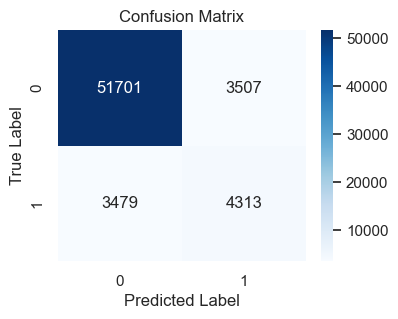

In [43]:
y_pred = dt_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
print("Akurasi pada data pelatihan:", train_accuracy)
print("\nAkurasi pada data pengujian:", test_accuracy)

Akurasi pada data pelatihan: 0.9138306878306879

Akurasi pada data pengujian: 0.8891111111111111


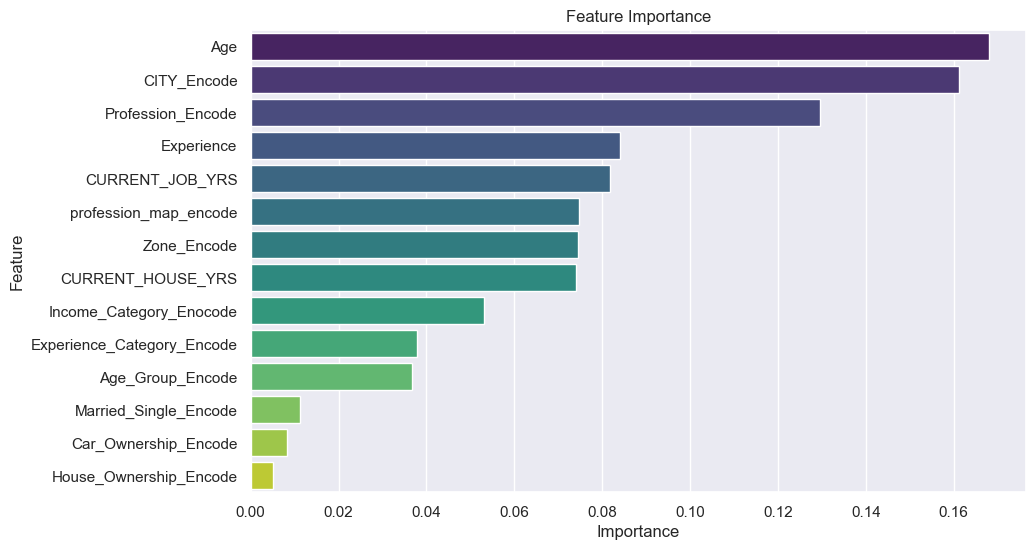

In [45]:
feature_importance = dt_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [46]:
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

train_sizes, train_scores, test_scores = learning_curve(
    dt_classifier, X_train, y_train, train_sizes=train_sizes, cv=5)

In [48]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [49]:
print('train_scores_mean', train_scores_mean, '\ntest_scores_mean', test_scores_mean)

train_scores_mean [0.92100529 0.92296296 0.91981746 0.91661943 0.91527631 0.91485714] 
test_scores_mean [0.86498942 0.88389418 0.88715344 0.88803175 0.88866667 0.88962434]


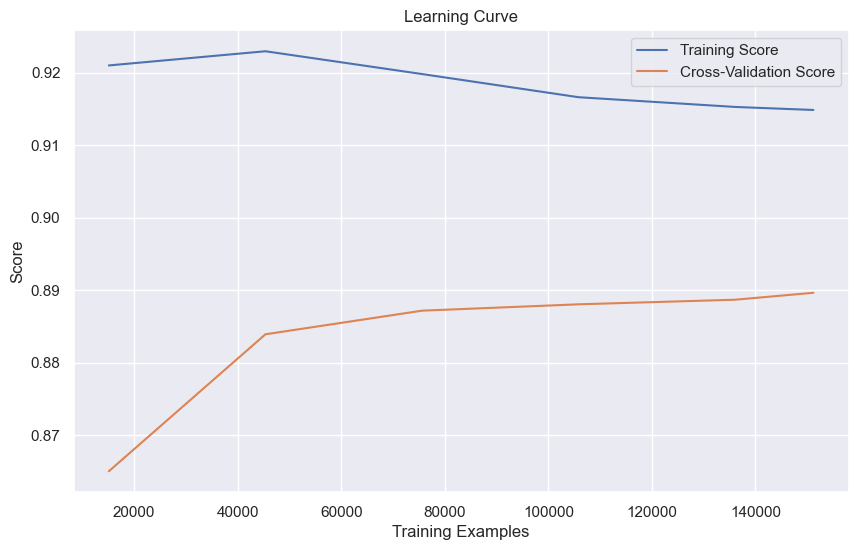

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()